**Set GPU**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ed86789d-7c9b-a158-45f2-012f9d167c29)


In [2]:
#@title Prepare Folders

#@markdown If you enable `google_drive` your outputs will be saved to **AI/Latent_Diffusion** otherwise they will be on the colab instance under **outputs** folder.
google_drive = True #@param {type:"boolean"}

#@markdown If you enable saving models you can avoid the download times each session. Models will be put in AI/models and take 6 GB.
save_models_to_google_drive = True #@param {type:"boolean"}

if google_drive:
    from google.colab import drive
    drive.mount('/content/gdrive')

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion" if google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")

Mounted at /content/gdrive
Model will be stored at /content/gdrive/MyDrive/AI/models
Outputs will be saved to /content/gdrive/MyDrive/AI/Latent_Diffusion


# **Install required libraries and set model.**

In [3]:
#@title Install libraries
!git clone https://github.com/mognc/taming-transformers.git
!git clone https://github.com/mognc/latent-diffusion.git
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1233, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1233 (delta 0), reused 0 (delta 0), pack-reused 1228
Receiving objects: 100% (1233/1233), 148.33 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Cloning into 'latent-diffusion'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 300 (delta 79), reused 76 (delta 76), pack-reused 177
Receiving objects: 100% (300/300), 31.17 MiB | 23.14 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 M

In [4]:
#@title Load model
%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt


/content/latent-diffusion
Using saved model from Google Drive


In [5]:
#@title 1.5 Define code

import argparse, os, sys, glob
import gc
import io
import json
import numpy as np
import random
import requests
import torch

from einops import rearrange
from glob import glob
from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from torchvision.utils import make_grid
from tqdm import tqdm, trange

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def run(opt):
    if opt.seed != -1:
        np.random.seed(opt.seed)
        random.seed(opt.seed)
        torch.manual_seed(opt.seed)
        torch.cuda.manual_seed_all(opt.seed)
        torch.backends.cudnn.deterministic = True

    config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml")  # TODO: Optionally download from same location as ckpt and chnage this logic
    model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

    if opt.plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt

    sample_path = outpath
    os.makedirs(sample_path, exist_ok=True)
    base_count = 0

    all_samples=list()
    with torch.no_grad():
        with model.ema_scope():
            uc = None
            if opt.scale > 0:
                uc = model.get_learned_conditioning(opt.n_samples * [""])
            for n in range(opt.n_iter):
                c = model.get_learned_conditioning(opt.n_samples * [prompt])
                shape = [4, opt.H//8, opt.W//8]
                samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                 conditioning=c,
                                                 batch_size=opt.n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,
                                                 eta=opt.ddim_eta)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                batch_images = []
                for x_sample in x_samples_ddim:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    Image.fromarray(x_sample.astype(np.uint8)).save(os.path.join(sample_path, f"{batch_name}({batch_index})_{base_count:04}.png"))
                    base_count += 1

                grid = torch.stack([x_samples_ddim], 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=opt.n_samples)
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                display.display(Image.fromarray(grid.astype(np.uint8)))

                if opt.save_grid:
                    all_samples.append(x_samples_ddim)


    # show grid of results
    if opt.save_grid:
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=opt.n_samples)
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
        display.clear_output()
        display.display(Image.fromarray(grid.astype(np.uint8)))


# **Generate Images**

Loading model from /content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


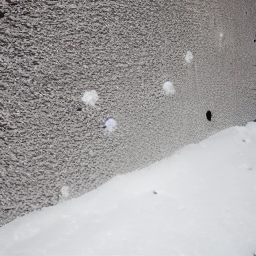

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


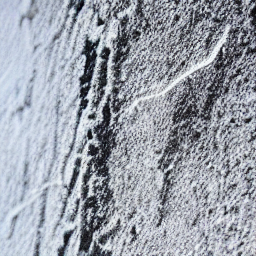

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


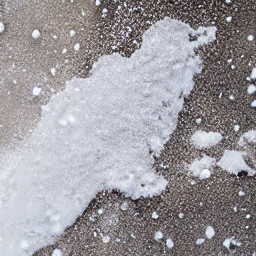

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


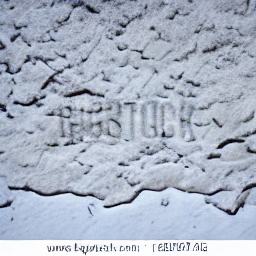

In [6]:
#@markdown Results saved to AI/Latent_Diffusion/`batch_name`

#@markdown The native resolution of the model is 256x256 but you can change `width_height` for larger dimensions than the network was trained for.

#@markdown `samples_per_batch` is how many images are generated in parallel. 4 is a good default for 16GB VRAM on Colab P100/V100 GPU.

#@markdown Optionally `create_grid` creates a grid of images for the batch. Turn it off when you want to do very large `num_batches`.

#@markdown For high quality renders I like to do ddim sampling, 250 steps, eta around 0.75

#@markdown

#@markdown ---

#@markdown ####**Settings:**
batch_name = 'Cracks' #@param{type: 'string'}
width_height = [256, 256] #@param{type: 'raw'}
samples_per_batch = 1 #@param{type: 'number'}
num_batches =  4   #@param{type: 'number'}
prompt = "A split crack in a wall with little bit snow." #@param{type: 'string'}
create_grid = False #@param {type: 'boolean'}
#@markdown ---
diffusion_sampling_mode = 'plms' #@param ['ddim','plms']
steps = 50#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
ddim_eta = 0.5 #@param{type: 'number'}
prompt_scale = 5 #@param{type: 'number'}
random_seed = -1 #@param{type: 'number'}


if random_seed == -1:
    random.seed()
    seed = random.randint(0, 2**32)
else:
    seed = random_seed

batch_path = f"{outputs_path}/{batch_name}"
batch_index = len(glob(batch_path+"/*.txt"))
while os.path.isfile(f"{batch_path}/{batch_name}({batch_index})_settings.txt"):
    batch_index += 1

settings = {
    'prompt': prompt,
    'width': width_height[0],
    'height': width_height[1],
    'steps': steps,
    'ddim_eta': ddim_eta,
    'prompt_scale': prompt_scale,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'random_seed': seed
}
!mkdir -p $batch_path
with open(f"{batch_path}/{batch_name}({batch_index})_settings.txt", "w+") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)

gc.collect()
torch.cuda.empty_cache()

import argparse
args = argparse.Namespace(
    prompt = prompt,
    outdir = f"{outputs_path}/{batch_name}",
    plms = diffusion_sampling_mode == 'plms',
    ddim_steps = steps,
    ddim_eta = ddim_eta if diffusion_sampling_mode == 'ddim' else 0,
    n_iter = num_batches,
    W = width_height[0],
    H = width_height[1],
    n_samples = samples_per_batch,
    scale = prompt_scale,
    seed = seed,
    save_grid = create_grid
)
run(args)
